[![Open In colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DatosGeograficos/2_Joins_y_Viz/2_Joins_Espaciales.ipynb)

# Joins Espaciales

I. Tabla de Contenidos

    I. Introducción
        I. Barrios
        II. Comisarías y divisiones
    II. Joins espaciales
    III. Ejercicios
    IV. Respuestas
        I. Ejercicio 1
        II. Ejercicio 2

In [ ]:
# !pip install geopandas
# !apt install libspatialindex-dev
# !pip install rtree
# !pip install pysal
# !pip install contextily --> Para importar mapa base

In [1]:
import pandas as pd
import geopandas
import shapely.wkt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import contextily as cx

In [3]:
def from_x_y(df, x, y, crs='EPSG:4326'):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1), # eliminamos las columnas originales
                                crs=crs, # Agregamos CRS
                                geometry=geopandas.points_from_xy(df[x], df[y])) # junto "x" e "y" y lo paso a Point
    return gdf

In [4]:
def from_wkt(df, wkt_column, crs='EPSG:4326'):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=crs) # seteamos la columna de geometría
    
    return gdf

## Introducción

Esta notebook es una introducción corta a los joins espaciales en GeoPandas. Sólo tiene por fin introducir el tema y supone vista la clase 1 de visualización.

Vamos a trabajar con tres capas: barrios, comisarias y divisiones de la Ciudad Autónoma de Buenos Aires.

### Barrios

In [5]:
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [6]:
barrios = from_wkt(barrios, "WKT")

### Comisarías y divisiones

Ahora vamos a cargar una versión modificada del dataset de comisarias de la policía de Buenos Aires y las distintas divisiones y área de cada comisaria.

- https://data.buenosaires.gob.ar/dataset/divisiones-comisarias-vecinales

- https://data.buenosaires.gob.ar/dataset/comisarias-policia-ciudad

In [7]:
comisarias = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/comisarias-policia-de-la-ciudad.csv")

In [8]:
comisarias = from_x_y(comisarias, "long", "lat")

In [9]:
comisarias.head()

,id,nombre,calle,altura,calle2,direccion,telefonos,observaciones,observaciones_2,geometry
0,1,Comisaria Vecinal 1-D,Lavalle,451,NaN,LAVALLE 451,4322-8033/8221,NaN,NaN,POINT (-58.37324 -34.60191)
1,37,Comisaria Vecinal 5-B,Muñiz,1250,NaN,MUÑIZ 1250,4922-1229 /4922-3333,NaN,NaN,POINT (-58.42493 -34.62864)
2,39,Comisaria Vecinal 6-A,Diaz Velez,5152,NaN,DIAZ VELEZ AV. 5152,4982-4509/4520,NaN,NaN,POINT (-58.43950 -34.60898)
3,8,Comisaria Vecinal 7-B,Valle,1454,NaN,VALLE 1454,4432-3334/3922,"Ubicada en comuna 6, dependencia comuna 7",NaN,POINT (-58.44809 -34.62678)
4,38,Comisaria Comunal 6,Avellaneda,1548,NaN,AVELLANEDA AV. 1548,4632-9051/9129,NaN,NaN,POINT (-58.45322 -34.62038)


In [10]:
divisiones = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/divisiones-comisarias-vecinales.csv")

In [11]:
divisiones = from_wkt(divisiones, "wkt")

In [12]:
divisiones.head()

,wkt,id,nombre,comuna,departamento,division,objeto,coordinates
0,MULTIPOLYGON (((-58.3813163424306 -34.59925863...,1,Comisaría Vecinal 1B,1,Comisaría Comunal 1,1B,Zona de Comisaría Vecinal,"MULTIPOLYGON (((-58.38132 -34.59926, -58.38130..."
1,MULTIPOLYGON (((-58.3773982761731 -34.61766034...,2,Comisaría Vecinal 1C,1,Comisaría Comunal 1,1C,Zona de Comisaría Vecinal,"MULTIPOLYGON (((-58.37740 -34.61766, -58.37740..."
2,MULTIPOLYGON (((-58.3694839346234 -34.59839738...,3,Comisaría Vecinal 1D,1,Comisaría Comunal 1,1D,Zona de Comisaría Vecinal,"MULTIPOLYGON (((-58.36948 -34.59840, -58.36937..."
3,MULTIPOLYGON (((-58.3685405568825 -34.57365006...,4,Comisaría Vecinal 1A,1,Comisaría Comunal 1,1A,Zona de Comisaría Vecinal,"MULTIPOLYGON (((-58.36854 -34.57365, -58.36852..."
4,MULTIPOLYGON (((-58.3704520636639 -34.63311595...,27,Comisaría Vecinal 4D,4,Comisaría Comunal 4,4D,Zona de Comisaría Vecinal,"MULTIPOLYGON (((-58.37045 -34.63312, -58.37045..."


## Joins espaciales

Dado que tenemos los polígonos de los barrios y de las divisiones, es de interés ver en qué medida se superponen o no. Para ello vamos a graficar ambas capas (y las comisarias), pero sólo mostrando los límites de los barrios y divisiones, sin mostrar el interior. Esto nos sirve para que la capa de arriba no tape a la de abajo.

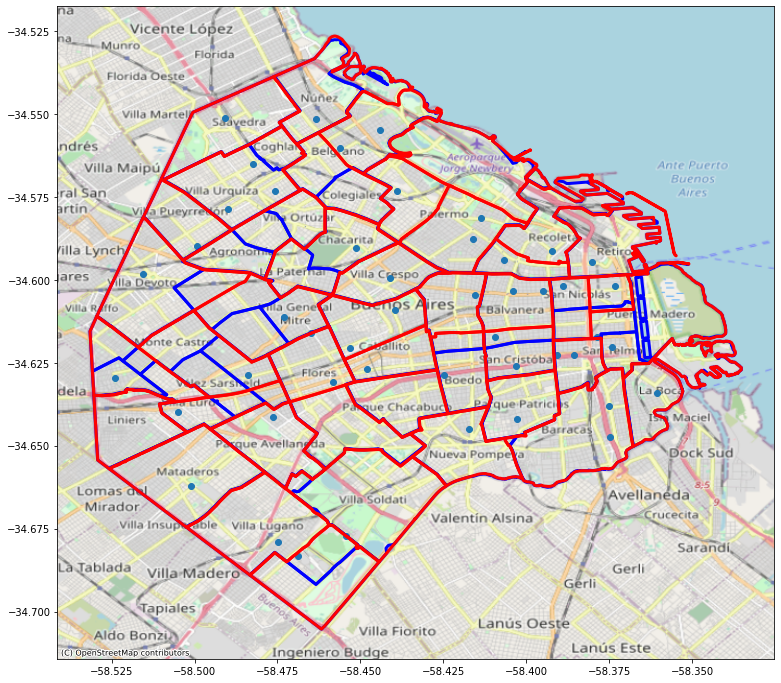

In [13]:
fig, ax = plt.subplots(figsize=(16, 12))
barrios.geometry.boundary.plot(ax=ax, linewidth=3, edgecolor='blue') # graficamos sólo los límites
divisiones.geometry.boundary.plot(ax=ax, linewidth=3, edgecolor='red')
comisarias.plot(ax=ax)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

GeoPandas permie, así como Pandas, realizas joins según columnas, a través de **merge** o **join**. Además, GeoPanas agrega la posibilidad de unir dos GeoDataFrames según una operación espacial. El método a emplear es **.sjoin** que tiene dos parámetros importantes: 

- how: que permite establecer si es un *left*, un *right* o un *inner*.

- op: consta de 3 operaciones geográficas:

    **intersects (interseca)**: los atributos se van a joinear si el límite o el interior de un objeto (geográfico) se interseca con el límite o el interior del otro objeto geográfico.
    
    **within (dentro)**: los atributos se van a joinear si el límite o el interior de un objeto (geográfico) se interseca sólo con el interior del otro objeto geográfico.

    **contains (contiene)**: los atributos se van a joinear si el interior del objeto contiene la frontera y el interior del otro objeto y sus límites no se tocan.


Puede consultarse la documentación en: http://geopandas.org/mergingdata.html

## Ejercicios

En base a la información de comisarias y de divisiones se nos pregunta:

1- ¿Cuántas comisarias hay en cada barrio?

2- ¿Cuántas comisarias hay por división?

Pero... no tan rápido! Para mayor certeza se nos requiere llegar al valor por dos métodos diferentes y corroborar que el valor obtenido sea el mismo. Tips: para ver si los métodos son equivalentes pueden comparar las series obtenidas usando el método **pd.Series.equals**: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.equals.html

## Respuestas
### Ejercicio 1

### Ejercicio 2